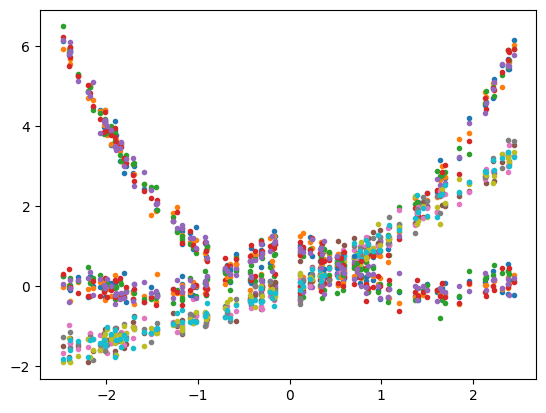

In [99]:
from matplotlib import pyplot as plt
import numpy as np
import torch


# Define the activation functions
def sin_activation(x):
    return np.sin(x)

def square_activation(x):
    return x**2

def bent_activation(x):
    return (np.sqrt(x ** 2 + 1) - 1) / 2 + x

def cos_activation(x):
    return np.cos(x)

def sinc_activation(x):
    return np.sinc(x)

task_list = [
    square_activation,
    square_activation,
    square_activation,
    square_activation,
    square_activation,
    bent_activation,
    bent_activation,
    bent_activation,
    bent_activation,
    bent_activation,
    sinc_activation,
    sinc_activation,
    sinc_activation,
    sinc_activation,
    sinc_activation,
]

input_dim = 1

# generate data
np.random.seed(0)
x_train = (np.random.rand(100, input_dim) - 0.5) * 5.0
x_valid = (np.random.rand(50, input_dim) - 0.5) * 5.0

delta_mag = 0.2

y_train = np.zeros([x_train.shape[0], 0])
y_valid = np.zeros([x_valid.shape[0], 0])
for task in task_list:
    y_train = np.hstack([y_train, task(x_train) + np.random.randn(x_train.shape[0], x_train.shape[1]) * delta_mag])
    y_valid = np.hstack([y_valid, task(x_valid) + np.random.randn(x_valid.shape[0], x_valid.shape[1]) * delta_mag])

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

for i in range(y_train.shape[1]):
    plt.plot(x_train, y_train[:, i], '.')

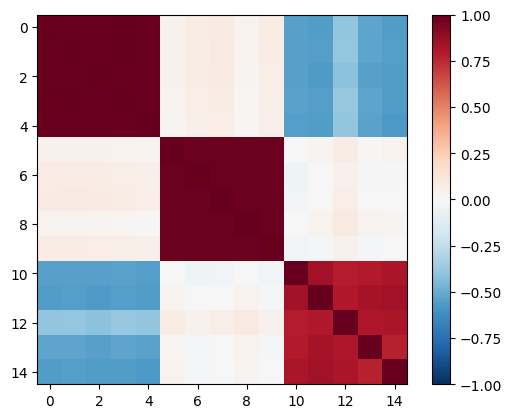

In [100]:
im = plt.imshow(np.corrcoef(y_train.T), 'RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im)

In [101]:
from torch import nn, optim
import sparsenn
from sparsenn import pareto

input_dim = x_train.shape[1]
hidden_dim = (16, 16, 16, )
output_dim = y_train.shape[1]

model = sparsenn.RegularizedMLP(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [102]:
# def train_optimal(model):

explored_values = []
frontier = []

max_epochs = int(1e6)

for k in range(17):
    lmbda_reg = 1e-5 * 2**k
    reg_prec = 3
    patience_interval = 1000
    last_best = 0
    model.train()
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        reg_loss = model.regularization_loss()
        total_loss = loss + lmbda_reg * reg_loss
        total_loss.backward()
        optimizer.step()
    
        point = np.array([loss.item(), np.round(reg_loss.item(), reg_prec)])
        explored_values.append(point)
        if not pareto.is_dominated(point, frontier):
            frontier = pareto.update_pareto_front(point, frontier)
            last_best = epoch
    
        if reg_loss.item() < 1:
            break
    
        if (epoch+1) % 1000 == 0:
            with torch.no_grad():
                outputs = model(x_valid)
                valid_loss = criterion(outputs, y_valid)
            print(f'Epoch {epoch+1}, MSE: {loss.item():.4f}, L0R: {reg_loss.item():.2f}, ValMSE: {valid_loss.item():.4f}')
        
        if epoch - last_best > patience_interval:
            print('Patience expired...')
            break
            
    # return explored_values, frontier

Epoch 1000, MSE: 0.5314, L0R: 550.07, ValMSE: 0.1795
Epoch 2000, MSE: 0.2581, L0R: 540.24, ValMSE: 0.1421
Epoch 3000, MSE: 0.0943, L0R: 532.79, ValMSE: 0.3006
Epoch 4000, MSE: 0.1024, L0R: 524.78, ValMSE: 0.0744
Epoch 5000, MSE: 0.0498, L0R: 515.56, ValMSE: 0.0629
Epoch 6000, MSE: 0.0477, L0R: 503.83, ValMSE: 0.0473
Epoch 7000, MSE: 0.0930, L0R: 491.02, ValMSE: 0.0466
Epoch 8000, MSE: 0.0396, L0R: 477.19, ValMSE: 0.0487
Epoch 9000, MSE: 0.0504, L0R: 463.07, ValMSE: 0.0449
Epoch 10000, MSE: 0.0443, L0R: 448.22, ValMSE: 0.0445
Epoch 11000, MSE: 0.0388, L0R: 431.99, ValMSE: 0.0718
Epoch 12000, MSE: 0.0357, L0R: 412.48, ValMSE: 0.0436
Epoch 13000, MSE: 0.0377, L0R: 392.44, ValMSE: 0.0439
Epoch 14000, MSE: 0.0354, L0R: 368.80, ValMSE: 0.0458
Epoch 15000, MSE: 0.0351, L0R: 344.26, ValMSE: 0.0440
Epoch 16000, MSE: 0.0348, L0R: 321.22, ValMSE: 0.0454
Epoch 17000, MSE: 0.0364, L0R: 301.33, ValMSE: 0.0461
Epoch 18000, MSE: 0.0365, L0R: 283.94, ValMSE: 0.0452
Epoch 19000, MSE: 0.0333, L0R: 267.93

Text(0, 0.5, 'Parameters')

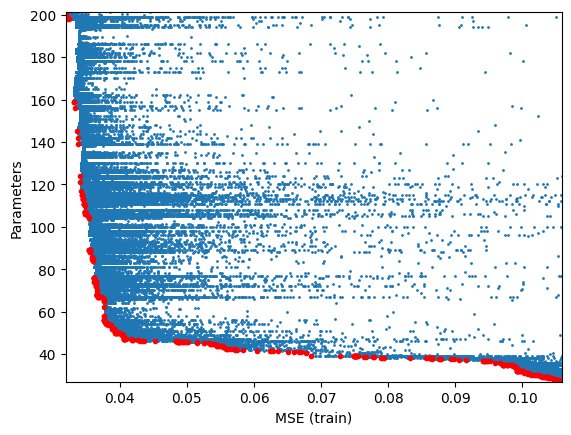

In [107]:
v = np.array(explored_values)
p = np.array(frontier)
# p = is_pareto_efficient(v, return_mask=True)
plt.scatter(*v.T, s=1, rasterized=True) # c=np.arange(v.shape[0]), 
plt.plot(p[:, 0], p[:, 1], 'r.')
plt.xlim(p[:, 0].min(), p[:, 0].max())
plt.ylim(p[:, 1].min(), p[:, 1].max())
plt.xlabel('MSE (train)')
plt.ylabel('Parameters')

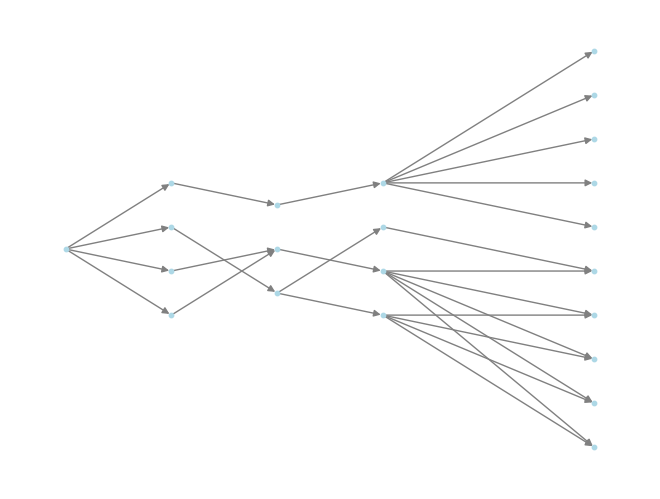

In [108]:
from sparsenn import viz

# Render the optimized architecture 
g = viz.gated_connections_graph(model) 
fig = viz.render_sparse_nn(g)

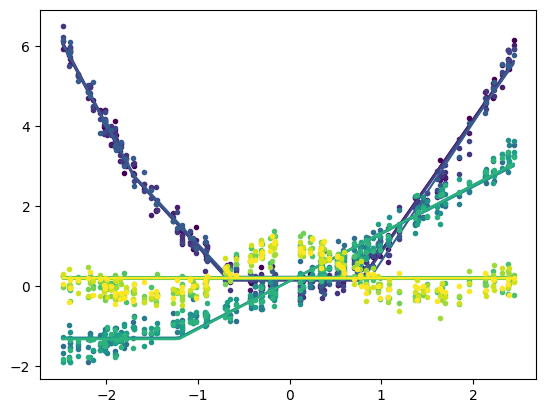

In [105]:
from matplotlib import cm

model.eval()

x_arr = torch.linspace(x_train.min(), x_train.max(), 101)
with torch.no_grad():
    output = model(x_arr.unsqueeze(1))
idx = np.argsort(x_train.numpy().flatten())
# colors = ['tab:blue', 'tab:cyan', 'tab:orange', 'tab:red', 'tab:purple', 'tab:pink']
# colors = cm.viridis(np.hstack([np.linspace(0, 0.25, 5), np.linspace(0.375, 0.625, 5), np.linspace(0.75, 1.0, 5)]))
colors = cm.viridis(np.linspace(0, 1, y_train.shape[1]))
for i in range(y_train.shape[1]):
    plt.plot(x_train[idx], y_train[idx, i], '.', c=colors[i])
    plt.plot(x_arr, output.numpy()[:, i], '-', c=colors[i])